[0.5, 0.255, 0.01]


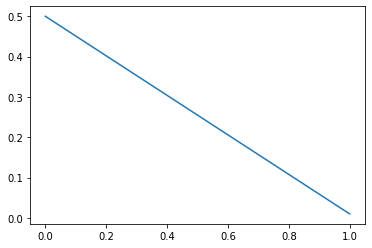

In [1]:
import numpy as np
import matplotlib.pyplot as plt

alpha_schedule_const = lambda progress: 0.025
alpha_schedule_linear = lambda progress: 0.01 + (0.5 - 0.01)*(1-progress)
alpha_decay = np.log(0.025)
alpha_schedule_exp = lambda progress: 0.4*np.exp(progress*alpha_decay)

alpha_schedule = alpha_schedule_linear
print([alpha_schedule(0), alpha_schedule(0.5), alpha_schedule(1)])

X = np.linspace(0, 1, 101)
Y = [alpha_schedule(x) for x in X]
plt.plot(X, Y)

In [2]:
from codetiming import Timer


import copy
from mcts import MCTS
from alphazerobot import AlphaZeroBot
import matplotlib.cm as cm
import matplotlib
import pickle as p
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 13}
matplotlib.rc('font', **font)

final_visits = []
class ToyGame:
    def __init__(self, length):
        self.length = length
        return

    def num_distinct_actions(self):
        return 4
    def new_initial_state(self):
        return State(0, self.length)

class State:
    def __init__(self, location1, length):
        self.location1 = location1
        self.length = length
        self.history_list = []
        self.terminal = False
        self.reward = 0

    def is_terminal(self):
        return self.terminal

    def current_player(self):
        if len(self.history_list) % 2 == 0:
            return 0
        else:
            return 1
    def history(self):
        return self.history_list

    def legal_actions(self, player):
        if self.current_player()==0:
            return [0, 1, 2]
        else:
            return [0]

    def information_state(self):
        return str(self.location1)

    def apply_action(self, action):
        if self.current_player() == 0:
            if len(self.history()) > length * 5:
                self.terminal = True
                self.reward = 0.
                return
            if action == 0:
                self.reward = -1.
                self.terminal = True
            if action == 1:
                self.location1 += 1
                if self.location1 == self.length:
                    self.reward = 0.1
                    self.terminal = True
            if action == 2:
                self.reward = 0.
                self.terminal = True
            if action == 3:
                if self.location1 > 0:
                    self.location1 -= 1
        self.history_list.append(action)


    def player_return(self, player):
        if player == 0:
            return self.reward
        else:
            return -self.reward

    def returns(self):
        return [self.reward, -self.reward]

    def clone(self):
        return copy.deepcopy(self)


def play_game_self(policy_fn, length, backup_type="on-policy", fw_greedy_targets=False, fw_lambda_targets=None, **kwargs):
    if isinstance(backup_type, str):
        backup_type = {backup_type}
    examples = []
    action_was_greedy_list = []
    game = ToyGame(length)
    state = game.new_initial_state()
    num_distinct_actions = game.num_distinct_actions()
    alphazero_bot = AlphaZeroBot(game, 0, policy_fn, self_play=True, **kwargs)
    while not state.is_terminal():
        policy, action = alphazero_bot.step(state)
        policy_dict = dict(policy)
        policy_list = []
        for i in range(num_distinct_actions):
            # Create a policy list. To be used in the net instead of a list of tuples.
            policy_list.append(policy_dict.get(i, 0.0))
        # Determine greedy (better remove dirichlet noise by looking at Q-values instead)
        root_Q = [child.Q if child.N > 0 else -99.0 for child in alphazero_bot.mcts.root.children.values()]
        greedy_action_value = max(root_Q)
        action_was_greedy_list.append(root_Q[action] >= greedy_action_value - 0.0001)
        # Create target dict
        targets = {}
        target = None
        # MC
#         if "on-policy" in backup_type:
#             targets["on-policy"] = None
        # Soft-Z
        if "soft-Z" in backup_type:
            target = -alphazero_bot.mcts.root.Q
            targets["soft-Z"] = target
        # A0C-2
        if "A0C-2" in backup_type:
#         if backup_type == "A0C-2":
            node = copy.deepcopy(alphazero_bot.mcts.root)
            value_list = {action_temp: (child.Q if child.N > 0 else -99.0) for action_temp, child in
                          node.children.items()}
            action_temp = max(value_list, key=value_list.get)
            target = - node.children[action_temp].V
            targets["A0C-2"] = target
        # TD
        if "A0C" in backup_type:
#         if backup_type == "A0C":
            target = greedy_action_value # max([child.Q if child.N > 0 else -99.0 for child in alphazero_bot.mcts.root.children.values()])
            targets["A0C"] = target
        # diff:
        if "off-policy" in backup_type or "hybrid" in backup_type:
#         if backup_type == "off-policy" or backup_type == "hybrid":
            node = copy.deepcopy(alphazero_bot.mcts.root)
            value_mult = 1
            while not node.is_leaf():
                value = node.Q
                value_list = {action_temp: (child.N+child.P if child.N>0 else -99.0) for action_temp, child in node.children.items()}
                action_temp = max(value_list, key=value_list.get)
                node = node.children[action_temp]
                value_mult *= -1
            if node.N > 0:
                value = node.Q
                value_mult *=-1
            target = value * value_mult
            targets["off-policy"] = target
            if "hybrid" in backup_type:
                A0C_value = max([child.Q if child.N > 0 else -99.0 for child in alphazero_bot.mcts.root.children.values()])
                target = (target + A0C_value)/2.0
                targets["hybrid"] = target
            #examples.append([state.information_state(), state.clone(), policy_list,  value * value_mult * 5.0**(-abs(value *value_mult + alphazero_bot.mcts.root.Q)), copy.deepcopy(alphazero_bot.mcts.root)])
        if backup_type == "off-policy2":
            node = copy.deepcopy(alphazero_bot.mcts.root)
            value_mult = 1
            value = node.Q
            value_list = {action_temp: (child.N if child.N > 0 else -99.0) for action_temp, child in
                          node.children.items()}
            action_temp = max(value_list, key=value_list.get)
            node = node.children[action_temp]
            value_mult *= -1
            while not node.is_leaf():
                value = node.Q
                value_list = {action_temp: (child.P) for action_temp, child in node.children.items()}
                action_temp = max(value_list, key=value_list.get)
                if node.children[action_temp].N>0:
                    node = node.children[action_temp]
                    value_mult *= -1
                else:
                    break
            if node.N > 0:
                value = node.Q
                value_mult *= -1
            examples.append([state.information_state(), state.clone(), policy_list, value*value_mult, copy.deepcopy(alphazero_bot.mcts.root)])
        if backup_type == "off-policy-lambda":
            node = copy.deepcopy(alphazero_bot.mcts.root)
            value_mult = 1
            lambda_value = 0.0
            step = 1
            value_tot = 0.0
            while not node.is_leaf():
                value_mult *= -1
                value = node.Q
                value_list = {action_temp: (child.N+child.P if child.N>0 else -99.0) for action_temp, child in node.children.items()}
                action_temp = max(value_list, key=value_list.get)
                node = node.children[action_temp]

                value_tot += value * value_mult * (1-lambda_value)*lambda_value**(step-1)
                step += 1

            if node.N > 0:
                value = node.Q
                value_mult *=-1
                value_tot += value * value_mult * (1-lambda_value)*lambda_value**(step-1)
                step += 1
            value_tot -= value * value_mult * (1-lambda_value)*lambda_value**(step-2)
            value_tot += value * value_mult * lambda_value**(step-2)
            examples.append([state.information_state(), state.clone(), policy_list, value_tot])
        if backup_type == "off-policy-lambda-2":
            node = copy.deepcopy(alphazero_bot.mcts.root)
            value_mult = 1
            lambda_value = 0.75
            step = 1
            value_tot = 0.0
            while not node.is_leaf():
                value_mult *= -1
                value = node.value
                value_list = {action_temp: (child.N+child.P if child.N>0 else -99.0) for action_temp, child in node.children.items()}
                action_temp = max(value_list, key=value_list.get)
                node = node.children[action_temp]

                value_tot += value * value_mult * (1-lambda_value)*lambda_value**(step-1)
                step += 1

            if node.N > 0:
                value = node.value
                value_mult *=-1
                value_tot += value * value_mult * (1-lambda_value)*lambda_value**(step-1)
                step += 1
            value_tot -= value * value_mult * (1-lambda_value)*lambda_value**(step-2)
            value_tot += value * value_mult * lambda_value**(step-2)
            examples.append([state.information_state(), state.clone(), policy_list, value_tot, copy.deepcopy(alphazero_bot.mcts.root)])

        examples.append([state.information_state(), state.clone(), policy_list, target, targets, copy.deepcopy(alphazero_bot.mcts.root)])
        state.apply_action(action)

    # Get return for starting player
    if "on-policy" in backup_type:
        reward = state.returns()[0]
        for i in reversed(range(len(examples))):
            examples[i][3] = reward # override target
            examples[i][4]["on-policy"] = reward # add to target dict
            reward *= -1
#     elif backup_type == "hybrid":
#         reward = state.returns()[0]
#         for i in reversed(range(len(examples))):
#             examples[i][3] = (examples[i][3] + reward)/2.0
#             reward *= -1
    if fw_lambda_targets:
        for i in reversed(range(len(examples)-1)):
            examples[i][3] = (1-fw_lambda_targets)*examples[i][3] + fw_lambda_targets*(-examples[i+1][3]) # mix target with next game state target
#             examples[i][3] = (1-fw_lambda_targets)*examples[i][3] + fw_lambda_targets*(examples[i+2][3]) # mix target with next game state target
            # print(f"Mixing {backup_type} l={fw_lambda_targets}")
    if fw_greedy_targets:
        for i in reversed(range(len(examples)-1)):
            if action_was_greedy_list[i]:
                examples[i][3] = -examples[i+1][3] # override target from next game state target
                # print(f"Do {backup_type} {i}")
    return examples

class PVTable:
    def __init__(self, length):
        self.values = np.ones((length, 2))*0.0
        self.V = []
        #self.values = np.random.randn(length, 2)*0.2

        self.policy = np.zeros((length, 2, 4)) + 0.25
        self.visits = np.zeros((length, 2))
        self.N = []

    def policy_fn(self, state):
        '''
        Returns a policy with "dirichlet noise"???
        '''
        loc1 = state.location1
        player = state.current_player()
        return list(self.policy[loc1, player, :]), self.values[loc1, player]


In [3]:
import datetime
now = datetime.datetime.now()

length = 8
# length = 6
n_games = 400
PROGRESS_GAME_INTERVAL = n_games/20
num_distinct_actions = 4

# Original parameters by Daniel W.
# alpha = 0.01
# alpha_p = 0.025

# New parameters
# alpha   = 0.05
# alpha_p = 0.05

fw_greedy_targets = True
fw_lambda_targets = None
# fw_lambda_targets = 0.9

c_puct = 2.5

# backup_types = ["on-policy", "soft-Z", "A0C", "off-policy"]
backup_types = ["on-policy", "soft-Z", "hybrid", "off-policy"]


# Create experiment file signature
lambda_name = f"{fw_lambda_targets:.2f}" if fw_lambda_targets else "None"
file_sig = f"{datetime.date.today()}_{now.hour}h FW={fw_greedy_targets} L={lambda_name} n_games={n_games}"
print(f"Running experiment {file_sig}")


def eval_backup_type(backup_type):
    pvtable = PVTable(length)
    for i_game in range(n_games):
        progress = i_game/(n_games-1)
        alpha = alpha_schedule(progress)
        alpha_p = alpha
        # Generate targets
        examples = play_game_self(pvtable.policy_fn, length,
                                  backup_type=backup_type, 
                                  fw_greedy_targets=fw_greedy_targets, 
                                  fw_lambda_targets = fw_lambda_targets,
                                  keep_search_tree=False, n_playouts=100, c_puct=c_puct, dirichlet_ratio=0.25)
        # Update policy/value table
        for example in examples:
            player = example[1].current_player()
            loc1 = example[1].location1
            policy = np.array(example[2])
            value = float(example[3])
            
            pvtable.visits[loc1, player] += 1
            
            pvtable.values[loc1, player] = (1-alpha)*pvtable.values[loc1, player] + alpha * value
            pvtable.policy[loc1, player, :] = (1-alpha_p)*pvtable.policy[loc1, player] + alpha_p * policy
        if i_game%PROGRESS_GAME_INTERVAL == 0 or i_game == n_games-1:
            # Print progress
            print(f"Progress {backup_type}: {progress:.1%}, alpha = {alpha:.4f}")
            #print(str(pvtable.policy[1,0,0]) + str(pvtable.values[1,0,0]) + str(pvtable.policy[3,0,0]) + str(pvtable.values[6,0,0])

            #print(str(pvtable.values[:,0]))
            #print(str(pvtable.policy[:,0,:]))

            #print(str(pvtable.visits[:,0]))
            pvtable.V.append(np.array(pvtable.values[:,0]))
            pvtable.N.append(np.array(pvtable.visits[:,0]))
    # print(str(pvtable.visits[:,0]))
    return pvtable

with Timer():
    final_visits = []
    pvtable = eval_backup_type(backup_types[0])
#     final_visits.append(pvtable.visits[:,0])
    final_visits.append(pvtable.N)
    pol_on = pvtable.policy[:, 0,:]
    values_on = pvtable.V


    pvtable = eval_backup_type(backup_types[1])
    final_visits.append(pvtable.N)
    pol_soft = pvtable.policy[:,0,:]
    values_soft = pvtable.V

    pvtable = eval_backup_type(backup_types[2])
    final_visits.append(pvtable.N)
    pol_A0C = pvtable.policy[:,0,:]
    values_A0C = pvtable.V

    pvtable = eval_backup_type(backup_types[3])
    final_visits.append(pvtable.N)
    pol_off = pvtable.policy[:,0,:]
    values_off = pvtable.V

    pol_total = [pol_on, pol_soft, pol_A0C, pol_off]
    values_total = [values_on, values_soft, values_A0C, values_off]


Running experiment 2020-07-02_15h FW=True L=None n_games=400
Progress on-policy: 0.0%, alpha = 0.5000
Progress on-policy: 5.0%, alpha = 0.4754
Progress on-policy: 10.0%, alpha = 0.4509
Progress on-policy: 15.0%, alpha = 0.4263
Progress on-policy: 20.1%, alpha = 0.4018
Progress on-policy: 25.1%, alpha = 0.3772
Progress on-policy: 30.1%, alpha = 0.3526
Progress on-policy: 35.1%, alpha = 0.3281
Progress on-policy: 40.1%, alpha = 0.3035
Progress on-policy: 45.1%, alpha = 0.2789
Progress on-policy: 50.1%, alpha = 0.2544
Progress on-policy: 55.1%, alpha = 0.2298
Progress on-policy: 60.2%, alpha = 0.2053
Progress on-policy: 65.2%, alpha = 0.1807
Progress on-policy: 70.2%, alpha = 0.1561
Progress on-policy: 75.2%, alpha = 0.1316
Progress on-policy: 80.2%, alpha = 0.1070
Progress on-policy: 85.2%, alpha = 0.0825
Progress on-policy: 90.2%, alpha = 0.0579
Progress on-policy: 95.2%, alpha = 0.0333
Progress on-policy: 100.0%, alpha = 0.0100
Progress soft-Z: 0.0%, alpha = 0.5000
Progress soft-Z: 5.0

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


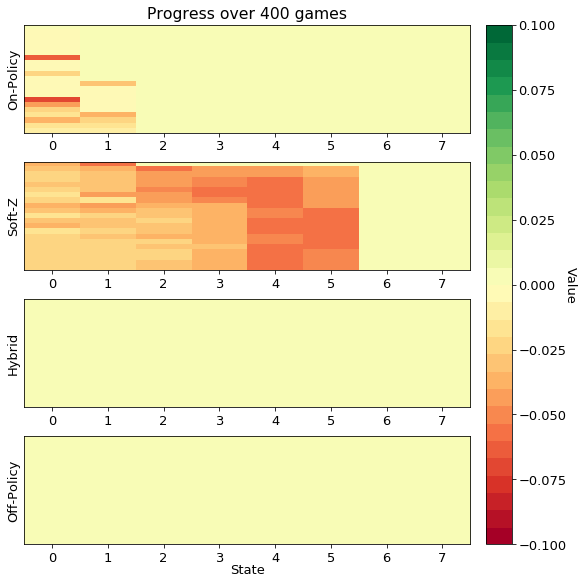

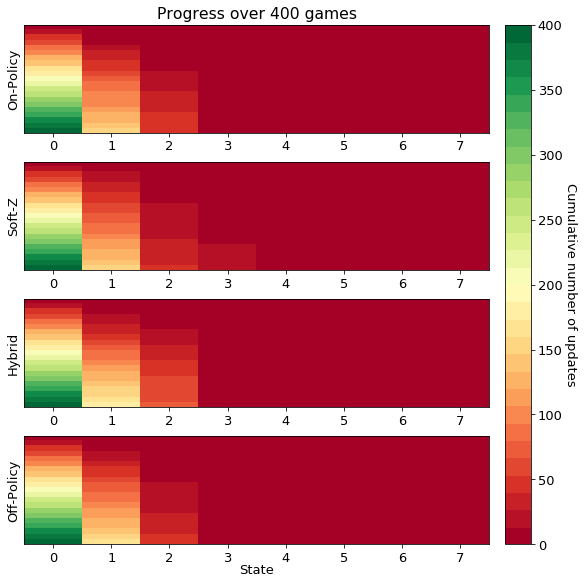

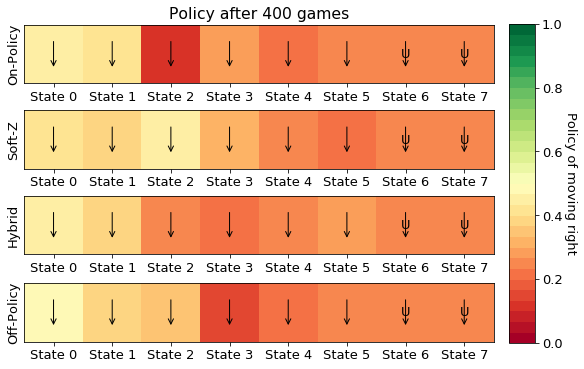

In [4]:

# obj0, obj1, obj2 are created here...

# Saving the objects:
with open('toy_res.pkl', 'wb') as f:  # Python 3: open(..., 'wb')
    p.dump([length,final_visits, values_total, pol_total], f)

# labels = ["On-policy", "Soft-Z", "A0C", "Off-policy"]
labels = [type_name.title() for type_name in backup_types]
cmap = cm.get_cmap('RdYlGn', 30)

i = 0
fig, axes = plt.subplots(nrows=len(values_total), ncols=1, figsize=(8,8), tight_layout=False, constrained_layout=True)
axes[0].set_title(f"Progress over {n_games} games")

fig.set_tight_layout(False)
for ax in axes.flat:
    #ax.set_axis_off()
#     im = ax.imshow(np.expand_dims(values_total[i],0), label=labels[i], cmap=cmap, vmin=-0.1, vmax=0.1)
    im = ax.imshow(values_total[i], label=labels[i], cmap=cmap, vmin=-0.1, vmax=0.1, aspect='auto')
    ax.set_ylabel(labels[i])
    ax.get_yaxis().set_ticks([])
    ax.set_xticks(np.arange(length))
    ax.set_xticklabels([str(i) for i in range(length)])
    i+=1

axes[-1].annotate("State", xy=(0.5, -0.3), xycoords=axes[-1].get_window_extent,
                  xytext=(0,0), textcoords="offset points", ha='center', va='bottom')

#fig.subplots_adjust(bottom=0.1, top=0.9, left=0.0, right=0.7,
#                    wspace=0.02, hspace=0.02)

#cb_ax = fig.add_axes([0.87, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, ax=axes)
cbar.set_label('Value', rotation=270, labelpad=10.5)
plt.savefig(f"Results/Value_{file_sig}.pdf", 
               bbox_inches='tight', 
               transparent=True,
               pad_inches=0.1)
# plt.show()

i = 0
fig, axes = plt.subplots(nrows=len(final_visits), ncols=1, figsize=(8,8), tight_layout=False, constrained_layout=True)
axes[0].set_title(f"Progress over {n_games} games")

fig.set_tight_layout(False)
for ax in axes.flat:
    #ax.set_axis_off()
#     im = ax.imshow(np.expand_dims(final_visits[i],0), label=labels[i], cmap=cmap)
    im = ax.imshow(np.array(final_visits[i]), label=labels[i], cmap=cmap, aspect='auto')
    ax.set_ylabel(labels[i])
    ax.get_yaxis().set_ticks([])
    ax.set_xticks(np.arange(length))
    ax.set_xticklabels([str(i) for i in range(length)])
    i+=1

axes[-1].annotate("State", xy=(0.5, -0.3), xycoords=axes[-1].get_window_extent,
                  xytext=(0,0), textcoords="offset points", ha='center', va='bottom')

#fig.subplots_adjust(bottom=0.1, top=0.9, left=0.0, right=0.7,
#                    wspace=0.02, hspace=0.02)

#cb_ax = fig.add_axes([0.87, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, ax=axes)
cbar.set_label('Cumulative number of updates', rotation=270, labelpad=14.5)
plt.savefig(f"Results/Visits_{file_sig}.pdf", 
               bbox_inches='tight', 
               transparent=True,
               pad_inches=0.1)



i = 0
fig, axes = plt.subplots(nrows=len(values_total),ncols=1, figsize=(8,5),constrained_layout=True)
axes[0].set_title(f"Policy after {n_games} games")

for ax in axes.flat:
    #ax.set_axis_off()
    for it, pol in enumerate(pol_total[i]):
        if int(np.argmax(pol)) == 0:
            pol_str = "U"
            ax.annotate("", xy=(it, 0.25), xytext=(it, -0.25), arrowprops=dict(arrowstyle="->"))
        elif int(np.argmax(pol)) == 1:
            pol_str = ""
            ax.annotate("", xy=(it+0.25, 0), xytext=(it-0.25, 0), arrowprops=dict(arrowstyle="->"))
        elif int(np.argmax(pol)) == 2:
            pol_str = ""
            ax.annotate("", xy=(it+0, 0.25), xytext=(it, -0.25), arrowprops=dict(arrowstyle="->"))
        else:
            pol_str = "L"
        ax.text(it, 0, pol_str, ha='center', va='center')
    im = ax.imshow(np.expand_dims(pol_total[i][:,1],0), label=labels[i], cmap=cmap, vmin=0.0, vmax=1.0)
    ax.set_ylabel(labels[i])
    ax.get_yaxis().set_ticks([])
    ax.set_xticks(np.arange(length))
    ax.set_xticklabels(["State " + str(i) for i in range(length)])
    i+=1

# axes[-1].annotate("State", xy=(0.5, -0.3), xycoords=axes[-1].get_window_extent,
#               xytext=(0,0), textcoords="offset points", ha='center', va='bottom')

# fig.subplots_adjust(bottom=0.1, top=0.9, left=0.0, right=0.9,
#                     wspace=0.02, hspace=0.02)

#cb_ax = fig.add_axes([0.87, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, ax=axes)
cbar.set_label('Policy of moving right', rotation=270, labelpad=14.5)
plt.savefig(f"Results/Policy_{file_sig}.pdf", 
               bbox_inches='tight', 
               transparent=True,
               pad_inches=0.1)
# plt.show()
# cax = ax1.imshow(values_total,  cmap=cmap)
# ax1.set_yticks(np.arange(len(labels)))
# ax1.set_yticklabels(labels)
# ax1.set_xticks(np.arange(length))
# ax1.set_xticklabels([str(i) for i in range(length)])

# plt.xlabel("State")
# fig.colorbar(cax)
# plt.show()
# length_cliff = 10
# start = [1,0]
#
# rewards = np.zeros((height, length_cliff))
# rewards[0,:] = -1
# rewards[0,-1] = 1
# rewards[-1,:] = 0.5
# print(rewards)

# breakpoint()


In [7]:
print("Values", values_total)

print("Policies", pol_total)

print("Visits", final_visits)

print(datetime.date.today())

Values [[array([0., 0., 0., 0., 0., 0., 0., 0.]), array([-1.57617143e-06,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), array([-6.36370405e-12,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), array([-4.73424143e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), array([-0.00637379,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ]), array([-3.36228059e-07,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00]), array([-0.06208422,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ]), array([-1.53752747e-05,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.

In [8]:
len(final_visits)

4

In [9]:
fw_lambda_targets = 0.9

backups_to_be_collected = {"on-policy", "soft-Z", "hybrid", "A0C", "off-policy"}

for i in range(6000):
    examples = play_game_self(pvtable.policy_fn, length,
                                  backup_type=backups_to_be_collected, 
                                  fw_greedy_targets=fw_greedy_targets, 
                                  fw_lambda_targets = fw_lambda_targets,
                                  keep_search_tree=False, n_playouts=100, c_puct=c_puct, dirichlet_ratio=0.25)
    if len(examples)>10:
        print(f"Success: length = {len(examples)}")
        break


from pprint import pprint

pprint(examples[0::2]) # first player moves
vars(examples[-1][-1])

Success: length = 11
[['0',
  [0.01, 0.58, 0.41, 0.0],
  0.0,
  {'A0C': 0.0,
   'hybrid': 0.0,
   'off-policy': 0.0,
   'on-policy': 0.0,
   'soft-Z': -0.019999999999999997},
 ['1',
  [0.03, 0.44, 0.53, 0.0],
  0.0,
  {'A0C': 0.0,
   'hybrid': 0.0,
   'off-policy': 0.0,
   'on-policy': 0.0,
   'soft-Z': -0.029999999999999975},
 ['2',
  [0.01, 0.26, 0.73, 0.0],
  0.0,
  {'A0C': 0.0,
   'hybrid': 0.0,
   'off-policy': 0.0,
   'on-policy': 0.0,
   'soft-Z': -0.019999999999999997},
 ['3',
  [0.03, 0.15, 0.82, 0.0],
  0.0,
  {'A0C': 0.0,
   'hybrid': 0.0,
   'off-policy': 0.0,
   'on-policy': 0.0,
   'soft-Z': -0.039999999999999994},
 ['4',
  [0.02, 0.33, 0.65, 0.0],
  0.0,
  {'A0C': 0.0,
   'hybrid': 0.0,
   'off-policy': 0.0,
   'on-policy': 0.0,
   'soft-Z': -0.05999999999999999},
 ['5',
  [0.03, 0.46, 0.51, 0.0],
  0.0,
  {'A0C': 0.0,
   'hybrid': 0.0,
   'off-policy': 0.0,
   'on-policy': 0.0,
   'soft-Z': -0.07000000000000003},


{'parent': None,
 'children': {0: <mcts.Node at 0x7f9a540ebc10>,
  1: <mcts.Node at 0x7f9a525d1ed0>,
  2: <mcts.Node at 0x7f9a524ecf10>},
 'P': 0.0,
 'Q': 0.07000000000000003,
 'N': 100,
 'use_puct': True}

In [10]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

0


<string>:6: UserWarning: Warning: converting a masked element to nan.
/Users/michaelkaisers/miniconda3/envs/openspiel/lib/python3.7/site-packages/numpy/ma/core.py:722: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


1
2
3
4
5


IndexError: list index out of range

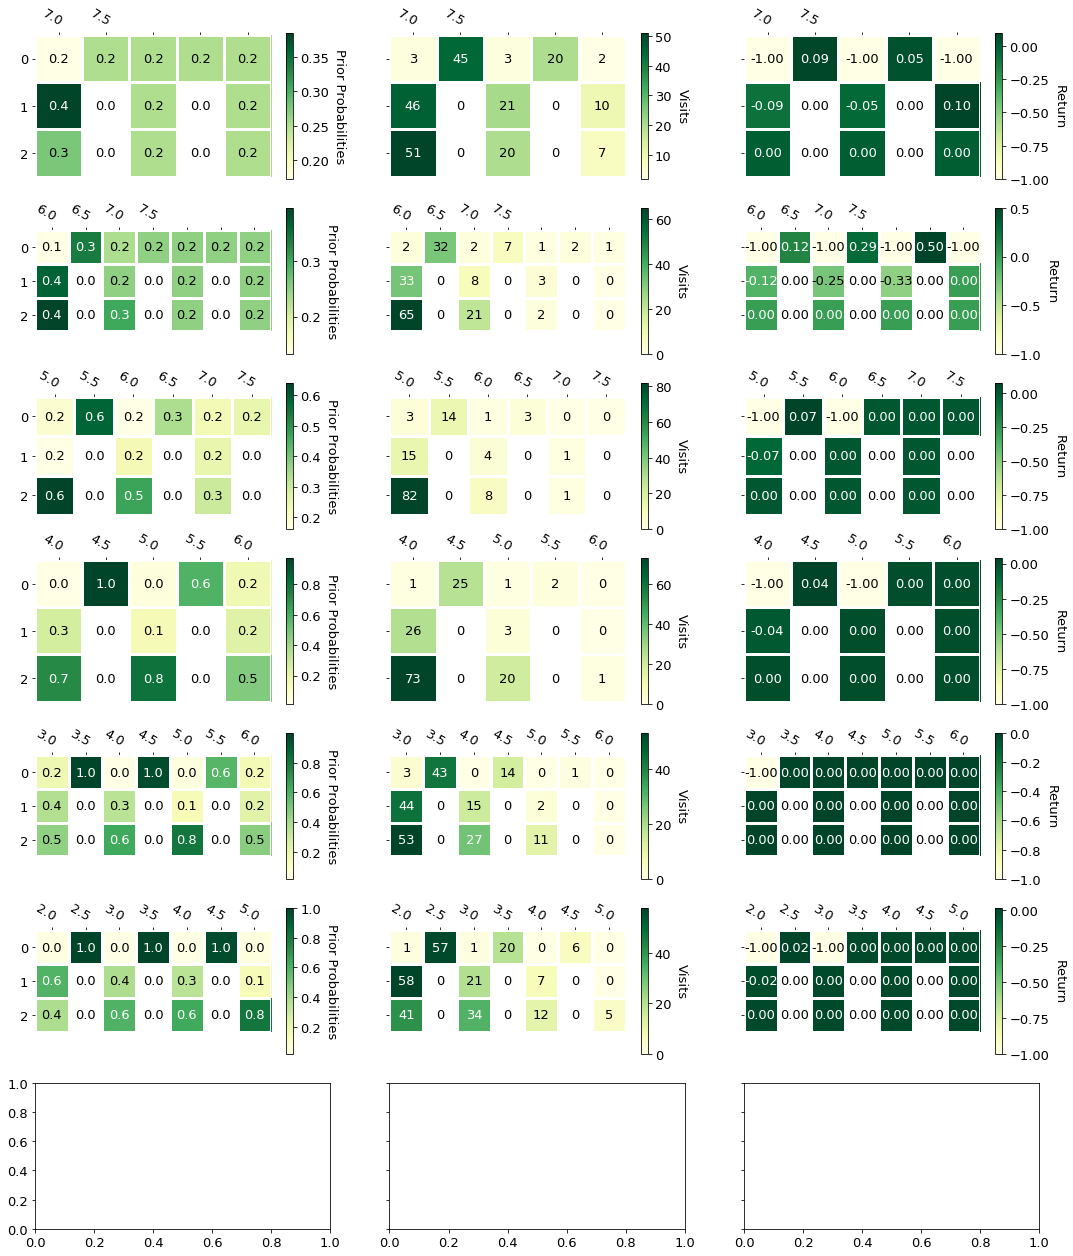

In [11]:


def make_tree(node, nc, fun):
#     print(node)
    d = vars(node)
    if len(d["children"])>0:
        cl = [np.NaN]*3
        for i, c in d["children"].items():
#             print(c)
            cl[i] = fun(c)
            make_tree(c, nc, fun)
        nc.append(cl)
    else:
        nc = vars(node)
#         nc.append(node)
    return


def resolve(node):
#     print(node)
    d = vars(node)
    if len(d["children"])>0:
        nc = {}
        for i, c in d["children"].items():
            nc[i] = resolve(c)
        d["children_expanded"] = nc
    return d

def make_plot(Q, label):
    fig, ax = plt.subplots()
    im, cbar = heatmap(Q, range(Q.shape[0]), range(Q.shape[1]), ax=ax,
                       cmap="YlGn", cbarlabel=label)
    texts = annotate_heatmap(im, valfmt="{x:.1f}")
    fig.tight_layout()
    plt.show()
    

    
def make_plots(P, N, Q, axes, position_from_last):
#     fig, axes = plt.subplots(1, 3, sharey='row', figsize=(18, 4))
    xlabels = np.array(range(2*length - 2 - 2*position_from_last, 2*length))/2.0
    print(position_from_last)
#     print(len(xlabels), P.shape[0])
    im, cbar = heatmap(P, range(P.shape[0]), xlabels, ax=axes[0],
                       cmap="YlGn", cbarlabel="Prior Probabilities")
    texts = annotate_heatmap(im, valfmt="{x:.1f}")
    
    im, cbar = heatmap(N, range(N.shape[0]), xlabels, ax=axes[1],
                       cmap="YlGn", cbarlabel="Visits")
    texts = annotate_heatmap(im, valfmt="{x:.0f}")
    
    im, cbar = heatmap(Q, range(Q.shape[0]), xlabels, ax=axes[2],
                       cmap="YlGn", cbarlabel="Return")
    texts = annotate_heatmap(im, valfmt="{x:.2f}")
#     fig.tight_layout()
#     plt.show()

# pprint(vars(examples[-1][-1]))
# pprint(resolve(examples[-3][-1]))

n_poss = 7
fig, axes = plt.subplots(n_poss, 3, sharey='row', figsize=(18, 22))
# fig, axes = plt.subplots(n_poss, 3, sharey='row', figsize=(18, 12))

for position_from_last in range(n_poss):
    leafs = []
    make_tree(examples[-1-2*position_from_last][-1], leafs, lambda n: n.P)
#     pprint(leafs)
    # plt.imshow(np.array(leafs[::-1]).T)
    # plt.colorbar()
    # plt.title("P")
#     make_plot(np.array(leafs[::-1]).T, "Prior Probabilities")
    P = np.array(leafs[::-1]).T

#     plt.figure()
    leafs = []
    make_tree(examples[-1-2*position_from_last][-1], leafs, lambda n: n.N)
#     pprint(leafs)
    # plt.imshow(np.array(leafs[::-1]).T)
    # plt.colorbar()
    # plt.title("N")
#     make_plot(np.array(leafs[::-1]).T, "Visits")
    N = np.array(leafs[::-1]).T

    leafs = []
#     plt.figure()
    make_tree(examples[-1-2*position_from_last][-1], leafs, lambda n: n.Q)
#     pprint(leafs)
    # plt.imshow(np.array(leafs[::-1]).T)
    # plt.colorbar()
    # plt.title("Q")
#     make_plot(np.array(leafs[::-1]).T, "Return")
    Q = np.array(leafs[::-1]).T
    make_plots(P, N, Q, axes[position_from_last], position_from_last)

plt.savefig(f"Results/Searchtree_{file_sig}.pdf", 
           bbox_inches='tight', 
           transparent=True,
           pad_inches=0.1)

In [ ]:
vars(examples[-1][-1])

In [19]:
[child.Q if child.N > 0 else -99.0 for child in vars(examples[-1][-1])["children"].values()]

[-1.0, -0.133062656641604, 0.0]

In [20]:
vars(examples[-1][1])

{'location1': 4,
 'length': 8,
 'history_list': [1, 0, 1, 0, 1, 0, 1, 0],
 'terminal': False,
 'reward': 0}